<a href="https://colab.research.google.com/github/kkoma2623/VisualComputing/blob/master/Vanilla_CVAE_(TF_2_0_w_TFP%2C_sigmoid)_kkoma2623.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!python --version

Python 3.6.9


In [0]:
import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp


from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.


Tensorflow:  2.2.0
Keras:  2.3.0-tf
Tensorflow Probability:  0.10.0


In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalizing the images to the range of [0., 1.]
train_images = train_images / 255.0
test_images = test_images / 255.0

# # binarization
# train_images[train_images >= 0.5] = 1.0
# train_images[train_images <  0.5] = 0.0
# test_images[test_images >= 0.5] = 1.0
# test_images[test_images <  0.5] = 0.0

# tensorflow probablity layer가 float32를 입력을 받기 때문에 float64를 float32로 캐스팅
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels[0].dtype)


(60000, 28, 28)
(10000, 28, 28)
(28, 28)
float32
uint8


## enc_dim을 2로 설정하고 train_labels와 test_labels를 원핫벡터로 만들어주었다.

In [0]:
tfd = tfp.distributions

enc_dim = 2

num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

print(train_label_onehots[0])
print(train_labels[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5


## 28*28 이미지를 784로 변환해주고 원핫벡터인 condition을 concatenate 하기 위해서 keras의 Sequential을 사용하지 않고 forward 방식으로 모델을 쌓았다.
* 인풋 레이어로 28,28 이미지와 10 인 원핫 벡터를 받는다.
* 28*28 이미지는 784로 변환해준다.
* concatenate 레이어를 통해서 784와 10을 합쳐서 794로 만든다.
* 794 -> 256 -> 128 -> 32 -> 4(2,2) -> 2

In [0]:
img = tf.keras.Input(shape=(28,28)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할


enc_dense_1 = tf.keras.layers.Dense(256, activation='relu')
enc_dense_2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense_3 = tf.keras.layers.Dense( 32, activation='relu')
enc_dense_4 = tf.keras.layers.Dense(enc_dim + enc_dim)
enc_tfp     = tfp.layers.IndependentNormal(enc_dim, 
                                activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0e-4))

flat_img = tf.keras.layers.Flatten()(img)
x = tf.keras.layers.concatenate([flat_img, con])
x = enc_dense_1(x)
x = enc_dense_2(x)
x = enc_dense_3(x)
x = enc_dense_4(x)
z = enc_tfp(x)

print(x.shape)
print(z)

(None, 4)
tfp.distributions.Independent("independent_normal_IndependentNormal_Independentindependent_normal_IndependentNormal_Normal", batch_shape=[?], event_shape=[2], dtype=float32)


## 인코더에서 출력한것ㄱ허 원핫벡터인 condition을 concatenate 하기 위해서 keras의 Sequential을 사용하지 않고 forward 방식으로 모델을 쌓았다.
* 인풋 레이어로 2와 10 인 원핫 벡터를 받는다.
* concatenate 레이어를 통해서 2와 10을 합쳐서 12로 만든다.
* 12 -> 64 -> 128 -> 256 -> 784(28*28) -> reshape (28,28)

In [0]:
dec_dense_1 = tf.keras.layers.Dense( 64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(28*28, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))

x = tf.keras.layers.concatenate([z, con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

In [0]:
cvae = tf.keras.Model(inputs=[img, con], outputs=y_pred)

In [0]:
# CVAE 모델 컴파일 (* loss 함수가 중요!)

cvae.compile(optimizer='adam',            
            #loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['mae'])

## 만든 모델을 그림을 통해 표현해보았다.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 794)          0           flatten[0][0]                    
                                                                 input_2[0][0]                

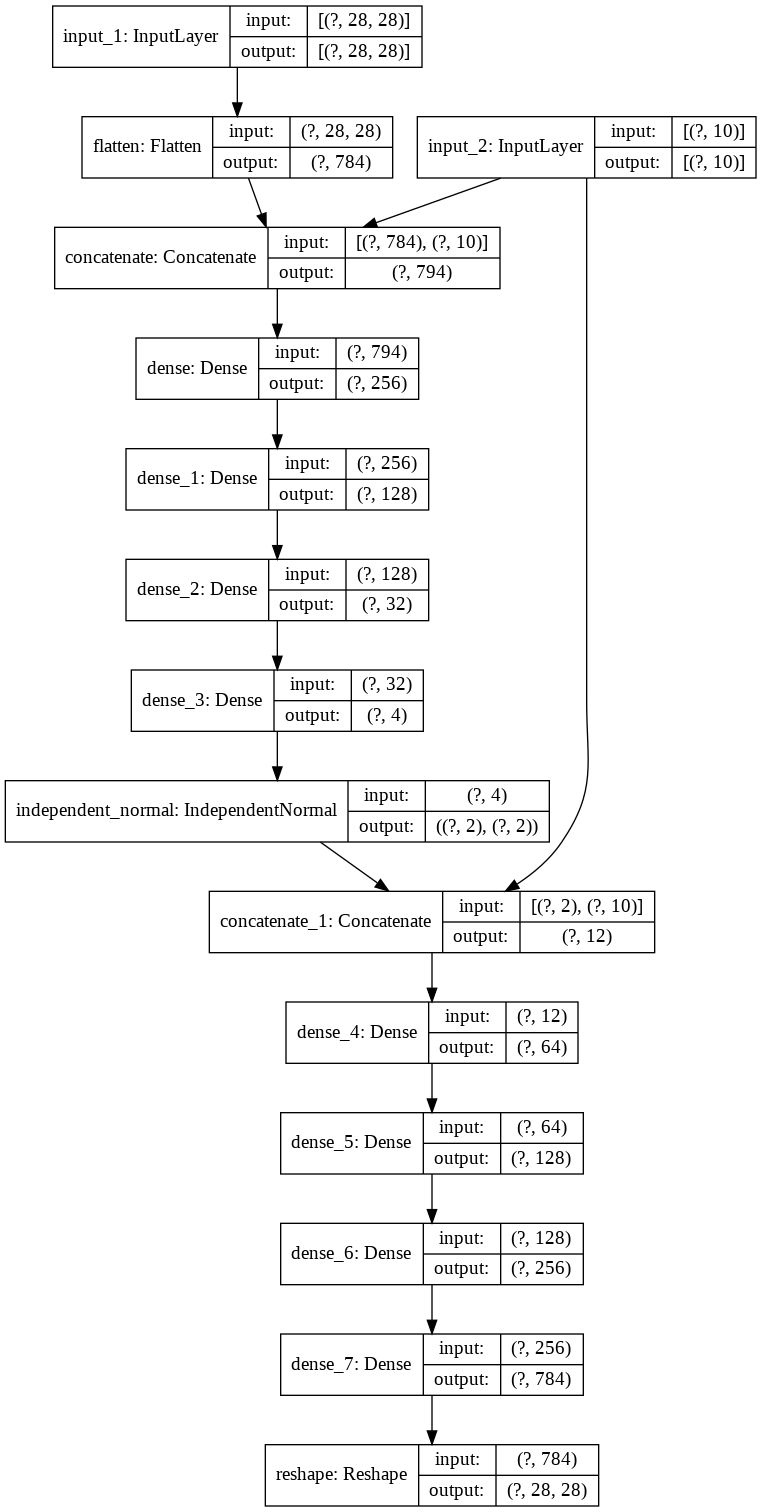

In [0]:
cvae.summary()
tf.keras.utils.plot_model(cvae, 'cvae_model.png', show_shapes=True)

## 에포크 20과 배치 사이즈는 100으로 하여 학습을 시켜보았다.
* 학습은 train_images 60,00장을 학습시켰다.

In [0]:
epochs = 20
batch_size = 100

cvae.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2131 - mae: 0.1168
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1738 - mae: 0.0896
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1692 - mae: 0.0862
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1667 - mae: 0.0843
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1650 - mae: 0.0831
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1639 - mae: 0.0823
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1631 - mae: 0.0817
Epoch 8/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1624 - mae: 0.0812
Epoch 9/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1618 - mae: 0.0808
Epoch 10/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1612 - mae: 0.0803
Epoch 11/20
600/600 [============================

In [0]:
results = cvae([train_images, train_label_onehots])

## 트레이닝이 끝난 CVAE를 이용하기
* 트레이닝이 끝난 CVAE는 함수로서 작동이 가능하다. 
* 학습한 데이터와 유사하게 그리는지 확인해보았다.
* 학습이 올바른 방향으로 된 것 같다

In [0]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

# 디코더를 이용한 Generative Model 구성
## 디코더 부분을 따로 모델로 설정하기
다음과 같은 방법으로 트레이닝이 끝난 조건부 오토인코더의 디코더를 모델로서 활용할 수 있다.

In [0]:
## input layer (special purposes for conditional generative model)
z_sample = layers.Input(shape=(enc_dim,))

## conditional generative model
cvae_cond = tf.keras.layers.concatenate([z_sample, con])
x_dec = dec_dense_1(cvae_cond)
x_dec = dec_dense_2(x_dec)
x_dec = dec_dense_3(x_dec)
x_dec = dec_dense_4(x_dec)
y_dec_pred = dec_reshape(x_dec)
print(y_dec_pred.shape)

cvae_decoder = models.Model([z_sample, con], y_dec_pred)

(None, 28, 28)


# 손글씨를 생성해보았다.
* 임의의 벡터와 one-hot 벡터를 입력으로 줘보았다.
* 그러기 위해서 one-hot 벡터를 IntSlider를 활용하여 만들고 싶은 손글씨를 선택하여 one-hot벡터를 수정할 수 있도록 하였다.
* 잘 생성해내는 벡터 값은 정규분포를 따르는 벡터이고 잘 생성해내지 못하는 벡터 값은 정규분포를 따르지 않는 것으로 유추할 수 있다.

## 임의의 값 벡터와 원핫벡터를 디코더에 입력으로 주었다.
* FloatSlider를 통해 소수점 둘째 자리까지 조정해서 넣어주도록 하였다.
* IntSlider를 통해 원 핫 벡터를 조정할 수 있게 했다.
* 정규분포를 따르는 벡터를 4가지 무작위로 출력하였다. 옆에 원핫벡터도 출력하였다.

In [0]:
## input layer (special purposes for conditional generative model)
z_img = tf.keras.Input(shape=(28,28)) # TF 1.x의 placeholder 역할
z_con = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할

## conditional generative model
z_flat_img = tf.keras.layers.Flatten()(z_img)
z_cond = layers.concatenate([z_flat_img, z_con], axis=1)
z_x = enc_dense_1(z_cond)
z_x = enc_dense_2(z_x)
z_x = enc_dense_3(z_x)
z_x = enc_dense_4(z_x)
z_enc = enc_tfp(z_x)
print(z_enc.shape)

cond_encoder = models.Model([z_img, z_con], z_enc)
z_cond_encoder = cond_encoder([train_images, train_label_onehots])

(None, 2)


## 의미있게 만들어진 이미지의 특징 관찰
* 정규분포를 따르며 라벨도 그에 맞는 원핫벡터를 디코더의 입력으로 주면 의미있게 만들어진 이미지를 생성하는 것을 볼 수 있다.
* 다만 정규분포를 따르지 않는 벡터를 입력으로 줄 경우 잘 생성해내지 못하는 경우가 있다.

In [0]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
v=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
i=widgets.IntSlider(min=0, max=9)

ui = widgets.HBox([u,v,i])
print("normal distribution vector example")
print(z_cond_encoder[0], train_label_onehots[0])
print(z_cond_encoder[10], train_label_onehots[10])
print(z_cond_encoder[100], train_label_onehots[100])
print(z_cond_encoder[2500], train_label_onehots[2500])
def z_test(u, v, i):
  z_test = np.array([[u,v]])
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  c_test[0][i] = 1.0
  print(z_test)
  print("one-hot vector > ", c_test)

  img_gen = cvae_decoder([z_test, c_test])
  plt.imshow(np.squeeze(img_gen[0]))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v, 'i':i})

display(ui, out)

normal distribution vector example
tf.Tensor([0.01446273 0.5351473 ], shape=(2,), dtype=float32) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tf.Tensor([0.27029037 0.8515767 ], shape=(2,), dtype=float32) [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
tf.Tensor([-0.25682366 -1.5182354 ], shape=(2,), dtype=float32) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tf.Tensor([0.9945695 0.4753322], shape=(2,), dtype=float32) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Output()

# 위에서 학습한 인코더를 가져왔다. 밑으로는 train_images 6000장으로 가시화 해보았다. 밑에 test_images 10000장으로도 가시화 해보겠다.
* train_images와 train_label_onehots를 입력으로 주었다.
* train_images = (60000, 28, 28)
* train_label_onehots = (60000, 10)

(5923, 2)
(6742, 2)
(5958, 2)
(5949, 2)


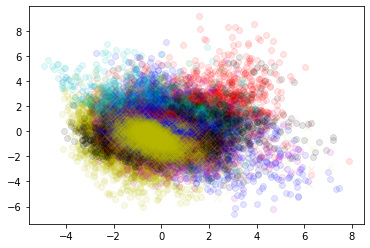

In [0]:
# import matplotlib.pyplot as plt

# pt = z.sample().numpy()

# plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
z_0 = z_cond_encoder[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_cond_encoder[train_labels==1]
z_2 = z_cond_encoder[train_labels==2]
z_3 = z_cond_encoder[train_labels==3]
z_4 = z_cond_encoder[train_labels==4]
z_5 = z_cond_encoder[train_labels==5]
z_6 = z_cond_encoder[train_labels==6]
z_7 = z_cond_encoder[train_labels==7]
z_8 = z_cond_encoder[train_labels==8]
z_9 = z_cond_encoder[train_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_9.shape)

plt.plot(z_0[:,0], z_0[:,1], 'ro', alpha=0.1)
plt.plot(z_1[:,0], z_1[:,1], 'yo', alpha=0.1)
plt.plot(z_2[:,0], z_2[:,1], 'bo', alpha=0.1)
plt.plot(z_3[:,0], z_3[:,1], 'go', alpha=0.1)
plt.plot(z_4[:,0], z_4[:,1], 'mo', alpha=0.1)
plt.plot(z_5[:,0], z_5[:,1], 'co', alpha=0.1)
plt.plot(z_6[:,0], z_6[:,1], 'ko', alpha=0.1)
plt.plot(z_7[:,0], z_7[:,1], 'rx', alpha=0.1)
plt.plot(z_8[:,0], z_8[:,1], 'bx', alpha=0.1)
plt.plot(z_9[:,0], z_9[:,1], 'yx', alpha=0.1)

#다음은 TSNE로 가시화해보았다.
* train_images 60,000장을 모두 보여주기에는 무리가 있어서 6,000장으로 slice하였다.
* 모두 비슷한 위치에서 찍히지만 condition에 따라서 다른 이미지를 생성할 수 있음을 유추할 수 있다.
* 학습한 데이터의 10퍼센트만 잘라서 출력하였는데 인코더의 출력값이 정규분포를 따르는 것을 확인할 수 있다.

(60000, 2)


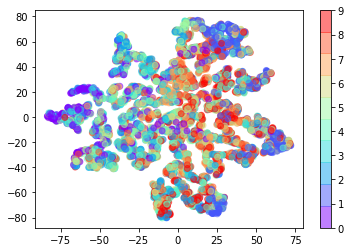

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100)
print(z_cond_encoder.shape)
transformed = model.fit_transform(z_cond_encoder[:6000, :])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=train_labels[:6000], cmap=plt.get_cmap('rainbow', 10), alpha=0.5)
plt.colorbar()
plt.show()

## 다음은 TSNE를 사용해서 각 조건별로 가시화 해보았다.
* 이것도 train_image의 10퍼센트인 6,000장만 그려보았다.
* 조건이 1을 제외한 나머지는 정규분포와 유사하게 그리는 모습을 관찰할 수 있다.

(60000, 2)


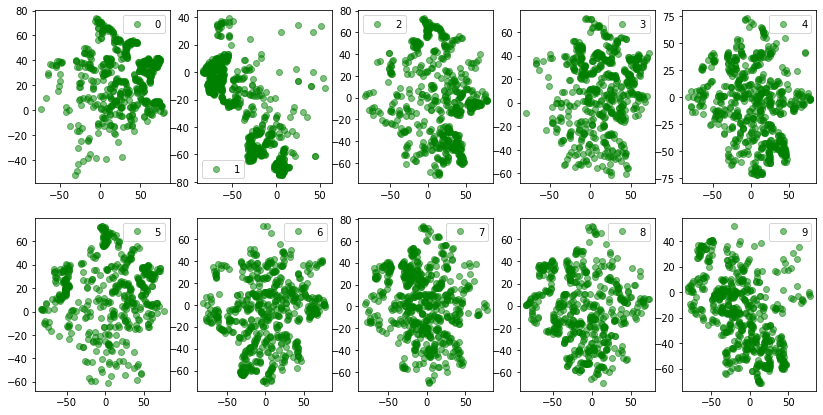

In [0]:
model_label = TSNE(learning_rate=100)
print(z_cond_encoder.shape)
transformed_label = model_label.fit_transform(z_cond_encoder[:6000, :])

xs_label = [[] for _ in range(10)]
ys_label = [[] for _ in range(10)]
for i, j in enumerate(train_labels[:6000]):
    xs_label[j].append(transformed_label[i][0])
    ys_label[j].append(transformed_label[i][1])

plt.figure(figsize=(14,7))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label[i - 1], ys_label[i - 1], 'go', label=str(i - 1), alpha=0.5)
    ax.legend()

plt.show()

## 다음은 디코더의 분포 가시화를 test_images에 대해서 같은 과정을 반복한 것이다.

In [0]:
cond_encoder_test = models.Model([z_img, z_con], z_enc)
z_cond_encoder_test = cond_encoder_test([test_images, test_label_onehots])

## test image에 대해서도 정규분포를 따르는 모습을 볼 수 있다.


(980, 2)
(1135, 2)
(1032, 2)
(1009, 2)


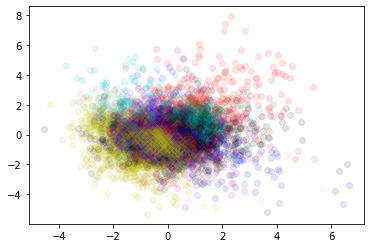

In [0]:
# import matplotlib.pyplot as plt

# pt = z.sample().numpy()

# plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
z_0_test = z_cond_encoder_test[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1_test = z_cond_encoder_test[test_labels==1]
z_2_test = z_cond_encoder_test[test_labels==2]
z_3_test = z_cond_encoder_test[test_labels==3]
z_4_test = z_cond_encoder_test[test_labels==4]
z_5_test = z_cond_encoder_test[test_labels==5]
z_6_test = z_cond_encoder_test[test_labels==6]
z_7_test = z_cond_encoder_test[test_labels==7]
z_8_test = z_cond_encoder_test[test_labels==8]
z_9_test = z_cond_encoder_test[test_labels==9]

print(z_0_test.shape)
print(z_1_test.shape)
print(z_2_test.shape)
print(z_9_test.shape)

plt.plot(z_0_test[:,0], z_0_test[:,1], 'ro', alpha=0.1)
plt.plot(z_1_test[:,0], z_1_test[:,1], 'yo', alpha=0.1)
plt.plot(z_2_test[:,0], z_2_test[:,1], 'bo', alpha=0.1)
plt.plot(z_3_test[:,0], z_3_test[:,1], 'go', alpha=0.1)
plt.plot(z_4_test[:,0], z_4_test[:,1], 'mo', alpha=0.1)
plt.plot(z_5_test[:,0], z_5_test[:,1], 'co', alpha=0.1)
plt.plot(z_6_test[:,0], z_6_test[:,1], 'ko', alpha=0.1)
plt.plot(z_7_test[:,0], z_7_test[:,1], 'rx', alpha=0.1)
plt.plot(z_8_test[:,0], z_8_test[:,1], 'bx', alpha=0.1)
plt.plot(z_9_test[:,0], z_9_test[:,1], 'yx', alpha=0.1)

## test images에서는 10,000개를 모두 출력해보았다.
* 정규분포를 따르며 모두 비슷한 위치에서 찍히지만 condition에 따라서 다른 출력을 하는 것을 유추할 수 있다.

(10000, 2)


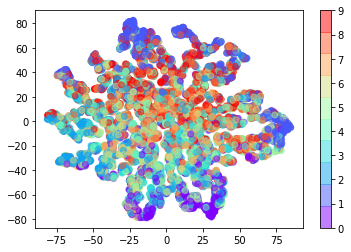

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_test = TSNE(learning_rate=100)
print(z_cond_encoder_test.shape)
transformed_test = model_test.fit_transform(z_cond_encoder_test[:, :])

xs_test = transformed_test[:,0]
ys_test = transformed_test[:,1]
plt.scatter(xs_test,ys_test,c=test_labels, cmap=plt.get_cmap('rainbow', 10), alpha=0.5)
plt.colorbar()
plt.show()

## TSNE를 사용하여 각 조건별로 정규분포를 따르는지 확인해보았다.
* train images로 가시화해본 것과 유사하게 조건 1을 제외하고는 모두 정규분포 모양을 하고 있는 것을 관찰할 수 있다.

(10000, 2)


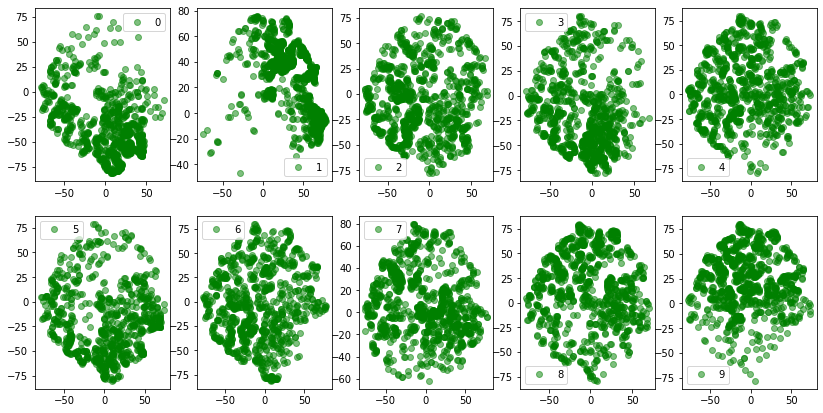

In [0]:
model_label_test = TSNE(learning_rate=100)
print(z_cond_encoder_test.shape)
transformed_label_test = model_label_test.fit_transform(z_cond_encoder_test[:, :])

xs_label_test = [[] for _ in range(10)]
ys_label_test = [[] for _ in range(10)]
for i, j in enumerate(test_labels):
    xs_label_test[j].append(transformed_label_test[i][0])
    ys_label_test[j].append(transformed_label_test[i][1])

plt.figure(figsize=(14,7))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label_test[i - 1], ys_label_test[i - 1], 'go', label=str(i - 1), alpha=0.5)
    ax.legend()

plt.show()

## enc_dim을 10으로 변화를 줘보았다.
* CVAE 모델은 위와 동일하다.
* 다만 인코더의 출력과 디코더가 입력으로 받는 벡터의 크기가 10으로 다르다

In [0]:
enc_dim = 10
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [0]:
img_2 = tf.keras.Input(shape=(28,28)) # TF 1.x의 placeholder 역할
con_2 = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할


enc_dense_1_2 = tf.keras.layers.Dense(256, activation='relu')
enc_dense_2_2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense_3_2 = tf.keras.layers.Dense( 32, activation='relu')
enc_dense_4_2 = tf.keras.layers.Dense(enc_dim + enc_dim)
enc_tfp_2     = tfp.layers.IndependentNormal(enc_dim, 
                                activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0e-4))

flat_img_2 = tf.keras.layers.Flatten()(img_2)
x_2 = tf.keras.layers.concatenate([flat_img_2, con_2])
x_2 = enc_dense_1_2(x_2)
x_2 = enc_dense_2_2(x_2)
x_2 = enc_dense_3_2(x_2)
x_2 = enc_dense_4_2(x_2)
z_2 = enc_tfp_2(x_2)

print(x_2.shape)
print(z_2)

(None, 20)
tfp.distributions.Independent("independent_normal_1_1_IndependentNormal_Independentindependent_normal_1_1_IndependentNormal_Normal", batch_shape=[?], event_shape=[10], dtype=float32)


In [0]:
dec_dense_1_2 = tf.keras.layers.Dense( 64, activation='relu')
dec_dense_2_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3_2 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4_2 = tf.keras.layers.Dense(28*28, activation='sigmoid')
dec_reshape_2 = tf.keras.layers.Reshape(target_shape=(28,28))

x_2 = tf.keras.layers.concatenate([z_2, con_2])
x_2 = dec_dense_1_2(x_2)
x_2 = dec_dense_2_2(x_2)
x_2 = dec_dense_3_2(x_2)
x_2 = dec_dense_4_2(x_2)
y_pred_2 = dec_reshape_2(x_2)

In [0]:
cvae_2 = tf.keras.Model(inputs=[img_2, con_2], outputs=y_pred_2)

In [0]:
# CVAE 모델 컴파일 (* loss 함수가 중요!)

cvae_2.compile(optimizer='adam',            
            #loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['mae'])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 794)          0           flatten_2[0][0]                  
                                                                 input_7[0][0]              

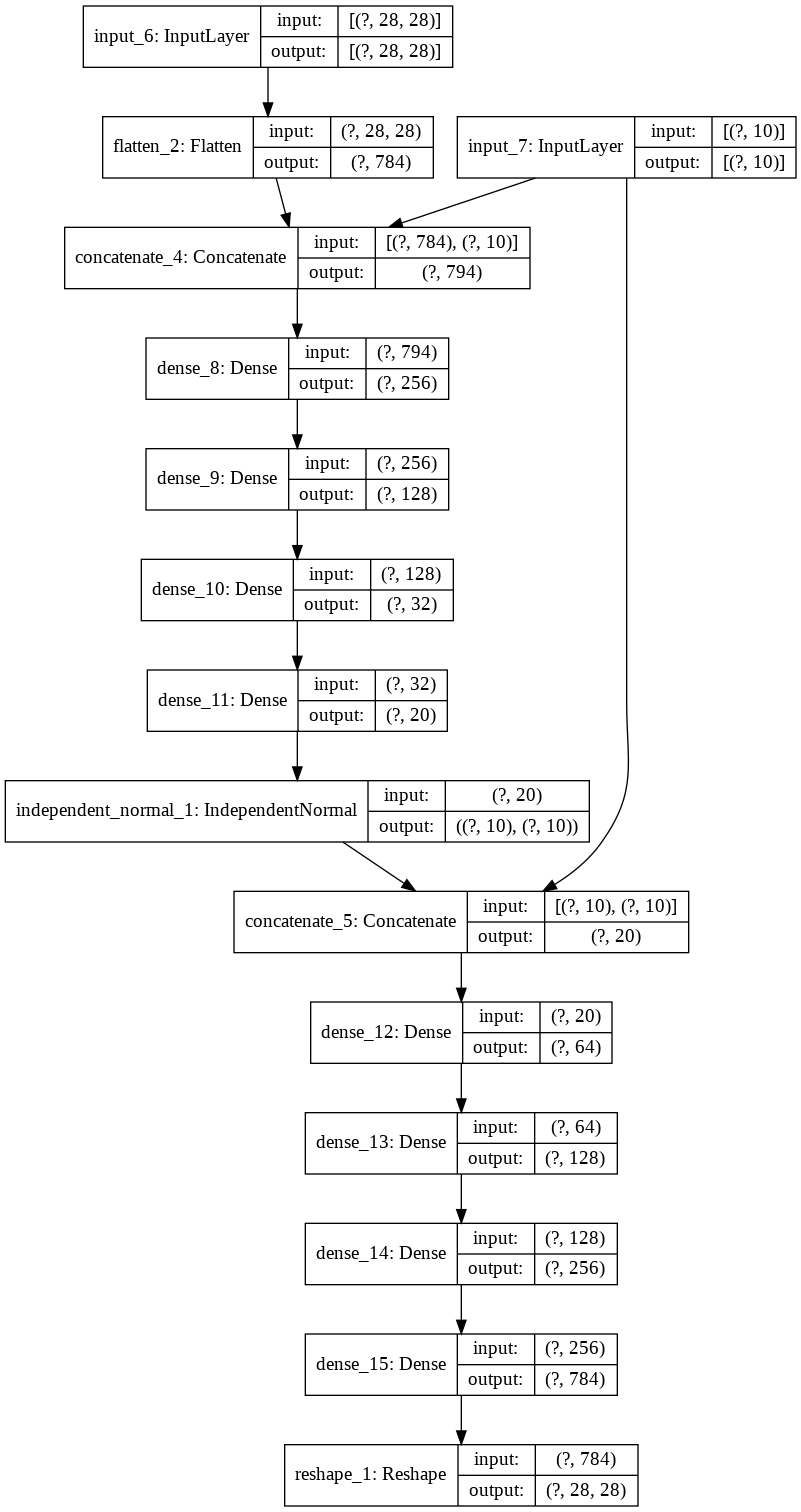

In [0]:
cvae_2.summary()
tf.keras.utils.plot_model(cvae_2, 'cvae_2_model.png', show_shapes=True)

## 위와 동일하게 학습하였다.

In [0]:
epochs = 20
batch_size = 100

cvae_2.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1944 - mae: 0.1018
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1365 - mae: 0.0610
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1268 - mae: 0.0541
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1220 - mae: 0.0507
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1187 - mae: 0.0483
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1163 - mae: 0.0467
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1144 - mae: 0.0453
Epoch 8/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1129 - mae: 0.0442
Epoch 9/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1117 - mae: 0.0434
Epoch 10/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1107 - mae: 0.0426
Epoch 11/20
600/600 [============================

## 트레이닝이 끝난 CVAE를 이용하기
* 트레이닝이 끝난 CVAE는 함수로서 작동이 가능하다. 
* 학습한 데이터와 유사하게 그리는지 확인해보았다.
* 학습이 올바른 방향으로 된 것 같다

In [0]:
results_2 = cvae_2([train_images, train_label_onehots])

In [0]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

def io_imshow_2(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results_2[idx])
  plt.show()

widgets.interact(io_imshow_2, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 임의의 값 벡터와 원핫벡터를 디코더에 입력으로 주었다.
* FloatSlider를 통해 소수점 둘째 자리까지 조정해서 넣어주도록 하였다.
* IntSlider를 통해 원 핫 벡터를 조정할 수 있게 했다.
* 정규분포를 따르는 벡터를 4가지 무작위로 출력하였다. 옆에 원핫벡터도 출력하였다.

## 손글씨를 생성해보았다.
* 임의의 벡터와 one-hot 벡터를 입력으로 줘보았다.
* 그러기 위해서 one-hot 벡터를 IntSlider를 활용하여 만들고 싶은 손글씨를 선택하여 one-hot벡터를 수정할 수 있도록 하였다.
* 잘 생성해내는 벡터 값은 정규분포를 따르는 벡터이고 잘 생성해내지 못하는 벡터 값은 정규분포를 따르지 않는 것으로 유추할 수 있다.

In [0]:
## input layer (special purposes for conditional generative model)
z_img_2 = tf.keras.Input(shape=(28,28)) # TF 1.x의 placeholder 역할
z_con_2 = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할

## conditional generative model
z_flat_img_2 = tf.keras.layers.Flatten()(z_img_2)
z_cond_2 = layers.concatenate([z_flat_img_2, z_con_2], axis=1)
z_x_2 = enc_dense_1_2(z_cond_2)
z_x_2 = enc_dense_2_2(z_x_2)
z_x_2 = enc_dense_3_2(z_x_2)
z_x_2 = enc_dense_4_2(z_x_2)
z_enc_2 = enc_tfp_2(z_x_2)
print(z_enc_2.shape)

cond_encoder_2 = models.Model([z_img_2, z_con_2], z_enc_2)
z_cond_encoder_2 = cond_encoder_2([train_images, train_label_onehots])

(None, 10)


In [0]:
## input layer (special purposes for conditional generative model)
z_sample_2 = layers.Input(shape=(enc_dim,))

## conditional generative model
cvae_cond_2 = tf.keras.layers.concatenate([z_sample_2, con_2])
x_dec_2 = dec_dense_1_2(cvae_cond_2)
x_dec_2 = dec_dense_2_2(x_dec_2)
x_dec_2 = dec_dense_3_2(x_dec_2)
x_dec_2 = dec_dense_4_2(x_dec_2)
y_dec_pred_2 = dec_reshape_2(x_dec_2)
print(y_dec_pred_2.shape)

cvae_decoder_2 = models.Model([z_sample_2, con_2], y_dec_pred_2)

(None, 28, 28)


## 의미있게 만들어진 이미지의 특징 관찰
* 정규분포를 따르며 라벨도 그에 맞는 원핫벡터를 디코더의 입력으로 주면 의미있게 만들어진 이미지를 생성하는 것을 볼 수 있다.
* 다만 정규분포를 따르지 않는 벡터를 입력으로 줄 경우 잘 생성해내지 못하는 경우가 있다.
* enc_dim이 10 이라서 정규분포를 따르는 벡터와 거의 유사하게 입력을 줘야만 의미있는 이미지를 생성해내고 그 외 정규분포와 동떨어진 벡터를 주면 이전보다 더 쉽게 이상한 이미지를 생성해내는 것을 관찰할 수 있다.

In [0]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
v=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
u2=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
v2=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
u3=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
v3=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
u4=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
v4=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
u5=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
v5=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)

i=widgets.IntSlider(min=0, max=9)

ui = widgets.HBox([u,v,u2,v2,u3,v3,u4,v4,u5,v5,i])
print("normal distribution vector sample")
print(z_cond_encoder_2[0], train_label_onehots[0])
print(z_cond_encoder_2[10], train_label_onehots[10])
print(z_cond_encoder_2[100], train_label_onehots[100])
print(z_cond_encoder_2[2500], train_label_onehots[2500])

def z_test_2(u,v,u2,v2,u3,v3,u4,v4,u5,v5,i):
  z_test_2 = np.array([[u,v,u2,v2,u3,v3,u4,v4,u5,v5]])
  c_test_2 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  c_test_2[0][i] = 1.0
  print(z_test_2)
  print("one-hot vector > ", c_test_2)

  img_gen_2 = cvae_decoder_2([z_test_2, c_test_2])
  plt.imshow(np.squeeze(img_gen_2[0]))
  plt.show()  

out_2 = widgets.interactive_output(z_test_2, {'u': u, 'v': v,'u2': u2, 'v2': v2,'u3': u3, 'v3': v3,'u4': u4, 'v4': v4,'u5': u5, 'v5': v5, 'i':i})

display(ui, out_2)

normal distribution vector sample
tf.Tensor(
[-1.6827134   0.4456147   0.33247346  0.5846929  -0.75874746  2.3087606
  0.87502694 -0.510362    1.9632806  -0.4351044 ], shape=(10,), dtype=float32) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tf.Tensor(
[-0.08079596 -0.13729218  1.0151147   0.7246746  -0.5202289   0.1554055
 -0.6567464  -0.546217    1.0340087  -0.5385687 ], shape=(10,), dtype=float32) [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
tf.Tensor(
[ 1.8883401  -1.0484313  -2.0570984  -1.1537338   0.7087229  -0.4298967
 -1.2871772  -0.15044776  1.0428559  -0.1055636 ], shape=(10,), dtype=float32) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tf.Tensor(
[ 0.0656513   1.3937125   1.4238093   0.9737528  -0.6593939  -1.3242147
  0.18291402  1.2508806  -0.88077503  2.0771697 ], shape=(10,), dtype=float32) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Output()

## TSNE를 사용해서 분포를 가시화해보았다.
* 조건을 모두 합친 것이 정규분포를 잘 따르는 모습이다.
* 다만 VAE 때 처럼 각 라벨별로 뭉쳐있는 모습을 볼 수 있다.

(60000, 10)


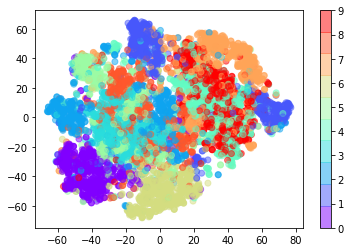

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_2 = TSNE(learning_rate=100)
print(z_cond_encoder_2.shape)
transformed_2 = model_2.fit_transform(z_cond_encoder_2[:6000, :])

xs_2 = transformed_2[:,0]
ys_2 = transformed_2[:,1]
plt.scatter(xs_2,ys_2,c=train_labels[:6000], cmap=plt.get_cmap('rainbow', 10), alpha=0.5)
plt.colorbar()
plt.show()

## 다음은 각 라벨별로 정규분포를 잘 따르는지 확인해보았다.
* 각 라벨별로 모두 정규분포를 잘 따르지 않는 모습을 관찰할 수 있다.

(60000, 10)
(6000, 2)
17.047148


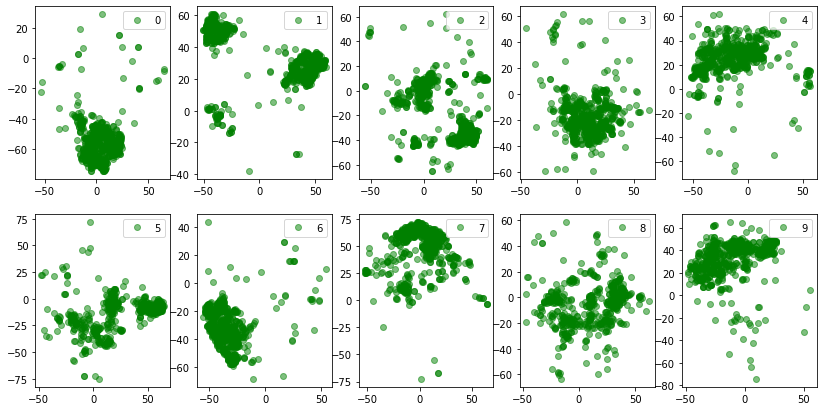

In [0]:
model_label_2 = TSNE(learning_rate=100)
print(z_cond_encoder_2.shape)
transformed_label_2 = model_label_2.fit_transform(z_cond_encoder_2[:6000, :])
print(transformed_label_2.shape)
print(transformed_label_2[0][0])
xs_label_2 = [[] for _ in range(10)]
ys_label_2 = [[] for _ in range(10)]
for i, j in enumerate(train_labels[:6000]):
    xs_label_2[j].append(transformed_label_2[i][0])
    ys_label_2[j].append(transformed_label_2[i][1])

plt.figure(figsize=(14,7))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label_2[i - 1], ys_label_2[i - 1], 'go', label=str(i - 1), alpha=0.5)
    ax.legend()

plt.show()

## 다음은 위의 가시화를 test images에 대해서 해본 것이다.
* 10개 값 중에서 앞의 두 값만 가져와서 가시화를 해보았다.
* 이는 정규분포를 잘 따르지만 의미있는 데이터 가시화라고 볼 수 없을 것 같다.

In [0]:
cond_encoder_test_2 = models.Model([z_img_2, z_con_2], z_enc_2)
z_cond_encoder_test_2 = cond_encoder_test_2([test_images, test_label_onehots])

(980, 10)
(1135, 10)
(1032, 10)
(1009, 10)


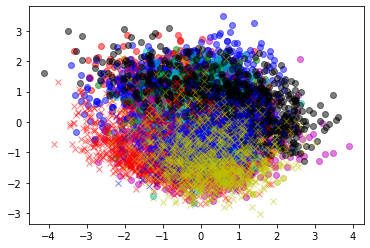

In [0]:
# import matplotlib.pyplot as plt

# pt = z.sample().numpy()

# plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
z_0_test_2 = z_cond_encoder_test_2[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1_test_2 = z_cond_encoder_test_2[test_labels==1]
z_2_test_2 = z_cond_encoder_test_2[test_labels==2]
z_3_test_2 = z_cond_encoder_test_2[test_labels==3]
z_4_test_2 = z_cond_encoder_test_2[test_labels==4]
z_5_test_2 = z_cond_encoder_test_2[test_labels==5]
z_6_test_2 = z_cond_encoder_test_2[test_labels==6]
z_7_test_2 = z_cond_encoder_test_2[test_labels==7]
z_8_test_2 = z_cond_encoder_test_2[test_labels==8]
z_9_test_2 = z_cond_encoder_test_2[test_labels==9]

print(z_0_test_2.shape)
print(z_1_test_2.shape)
print(z_2_test_2.shape)
print(z_9_test_2.shape)

plt.plot(z_0_test_2[:,0], z_0_test_2[:,1], 'ro', alpha=0.5)
plt.plot(z_1_test_2[:,0], z_1_test_2[:,1], 'yo', alpha=0.5)
plt.plot(z_2_test_2[:,0], z_2_test_2[:,1], 'bo', alpha=0.5)
plt.plot(z_3_test_2[:,0], z_3_test_2[:,1], 'go', alpha=0.5)
plt.plot(z_4_test_2[:,0], z_4_test_2[:,1], 'mo', alpha=0.5)
plt.plot(z_5_test_2[:,0], z_5_test_2[:,1], 'co', alpha=0.5)
plt.plot(z_6_test_2[:,0], z_6_test_2[:,1], 'ko', alpha=0.5)
plt.plot(z_7_test_2[:,0], z_7_test_2[:,1], 'rx', alpha=0.5)
plt.plot(z_8_test_2[:,0], z_8_test_2[:,1], 'bx', alpha=0.5)
plt.plot(z_9_test_2[:,0], z_9_test_2[:,1], 'yx', alpha=0.5)

## 다음은 TSNE를 통해서 가시화를 해보았다.
* 10차원을 2차원으로 줄여서 가시화를 하였다.
* 정규분포를 잘 따르는 것을 볼 수 있다.
* 하지만 위와 마찬가지로 각 라벨별로 뭉쳐있는 것을 볼 수 있다.

(10000, 10)


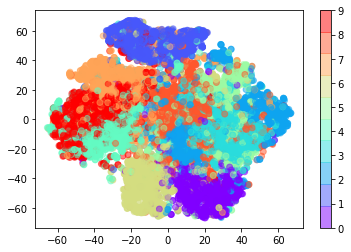

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_test_2 = TSNE(learning_rate=100)
print(z_cond_encoder_test_2.shape)
transformed_test_2 = model_test_2.fit_transform(z_cond_encoder_test_2[:, :])

xs_test_2 = transformed_test_2[:,0]
ys_test_2 = transformed_test_2[:,1]
plt.scatter(xs_test_2,ys_test_2,c=test_labels, cmap=plt.get_cmap('rainbow', 10), alpha=0.5)
plt.colorbar()
plt.show()

## 다음은 TSNE를 사용해서 각 조건별로 정규분포를 따르는지 확인해보았다.
* 위와 마찬가지로 각 라벨별로는 정규분포를 잘 따르지 않는 것 같다.

(10000, 10)


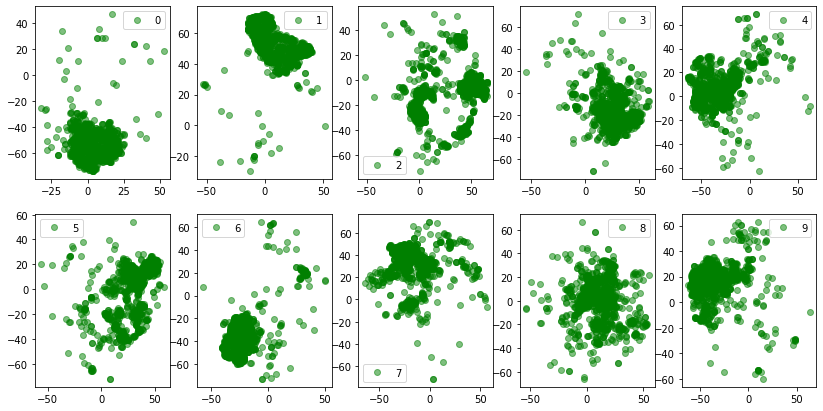

In [0]:
model_label_test_2 = TSNE(learning_rate=100)
print(z_cond_encoder_test_2.shape)
transformed_label_test_2 = model_label_test_2.fit_transform(z_cond_encoder_test_2[:, :])

xs_label_test_2 = [[] for _ in range(10)]
ys_label_test_2 = [[] for _ in range(10)]
for i, j in enumerate(test_labels):
    xs_label_test_2[j].append(transformed_label_test_2[i][0])
    ys_label_test_2[j].append(transformed_label_test_2[i][1])

plt.figure(figsize=(14,7))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label_test_2[i - 1], ys_label_test_2[i - 1], 'go', label=str(i - 1), alpha=0.5)
    ax.legend()

plt.show()

In [0]:
print(transformed_label_test_2.shape)

(10000, 2)


## enc_dim을 3으로 변화를 줘보았다.
* 10으로 하니 각 조건별로 정규분포를 잘 따르지 않는 것 같아서 3으로 줄여보았다.

In [0]:
enc_dim = 3
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [0]:
img_3 = tf.keras.Input(shape=(28,28)) # TF 1.x의 placeholder 역할
con_3 = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할


enc_dense_1_3 = tf.keras.layers.Dense(256, activation='relu')
enc_dense_2_3 = tf.keras.layers.Dense(128, activation='relu')
enc_dense_3_3 = tf.keras.layers.Dense( 32, activation='relu')
enc_dense_4_3 = tf.keras.layers.Dense(enc_dim + enc_dim)
enc_tfp_3     = tfp.layers.IndependentNormal(enc_dim, 
                                activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0e-4))

flat_img_3 = tf.keras.layers.Flatten()(img_3)
x_3 = tf.keras.layers.concatenate([flat_img_3, con_3])
x_3 = enc_dense_1_3(x_3)
x_3 = enc_dense_2_3(x_3)
x_3 = enc_dense_3_3(x_3)
x_3 = enc_dense_4_3(x_3)
z_3 = enc_tfp_3(x_3)

print(x_3.shape)
print(z_3)

(None, 6)
tfp.distributions.Independent("independent_normal_2_IndependentNormal_Independentindependent_normal_2_IndependentNormal_Normal", batch_shape=[?], event_shape=[3], dtype=float32)


In [0]:
dec_dense_1_3 = tf.keras.layers.Dense( 64, activation='relu')
dec_dense_2_3 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4_3 = tf.keras.layers.Dense(28*28, activation='sigmoid')
dec_reshape_3 = tf.keras.layers.Reshape(target_shape=(28,28))

x_3 = tf.keras.layers.concatenate([z_3, con_3])
x_3 = dec_dense_1_3(x_3)
x_3 = dec_dense_2_3(x_3)
x_3 = dec_dense_3_3(x_3)
x_3 = dec_dense_4_3(x_3)
y_pred_3 = dec_reshape_3(x_3)

In [0]:
cvae_3 = tf.keras.Model(inputs=[img_3, con_3], outputs=y_pred_3)

In [0]:
# CVAE 모델 컴파일 (* loss 함수가 중요!)

cvae_3.compile(optimizer='adam',            
            #loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['mae'])

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 784)          0           input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 794)          0           flatten_4[0][0]                  
                                                                 input_12[0][0]             

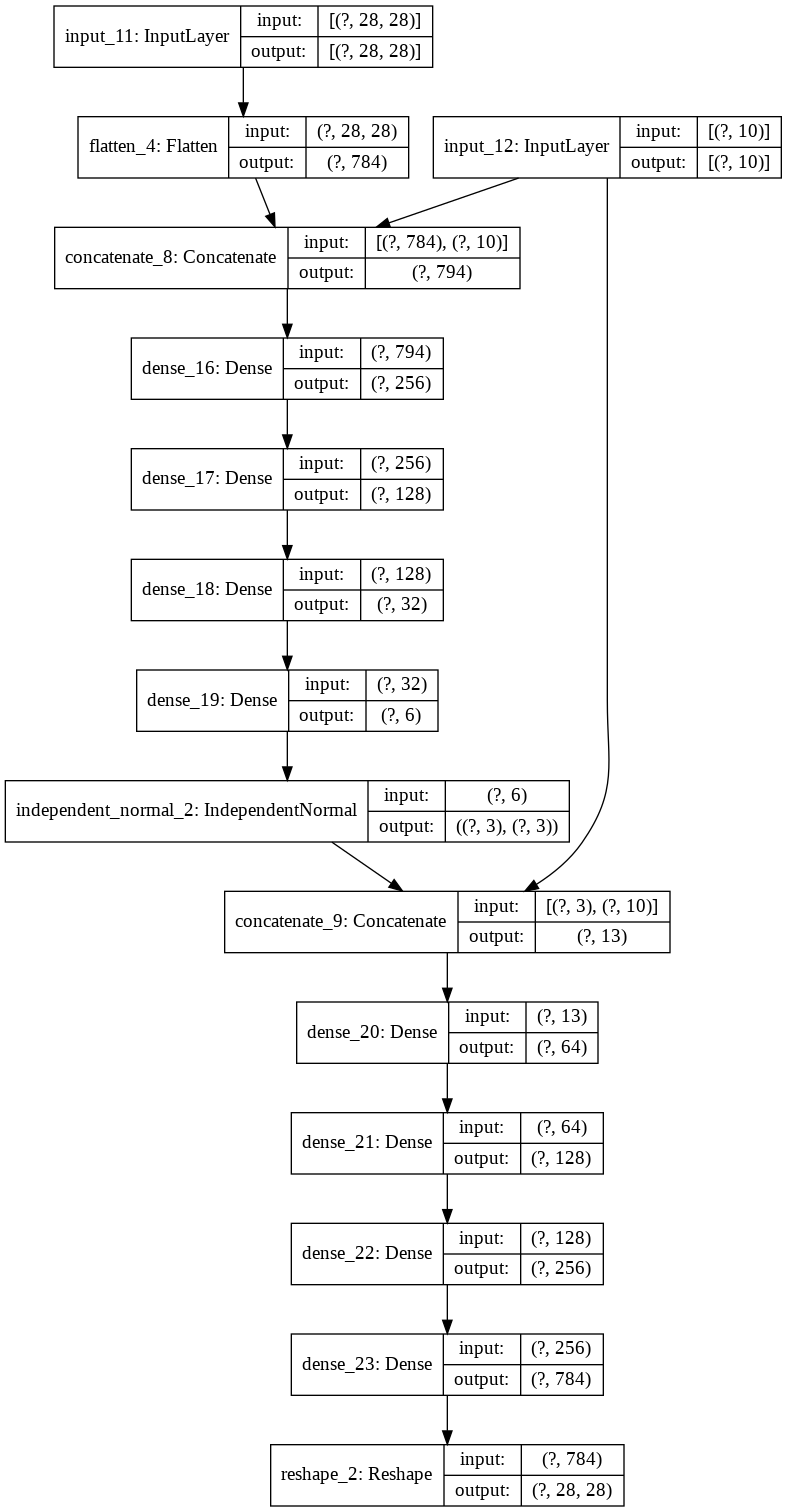

In [0]:
cvae_3.summary()
tf.keras.utils.plot_model(cvae_3, 'cvae_3_model.png', show_shapes=True)

## 위와 동일하게 학습하였다.

In [0]:
epochs = 20
batch_size = 100

cvae_3.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2138 - mae: 0.1171
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1656 - mae: 0.0838
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1588 - mae: 0.0788
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1555 - mae: 0.0763
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1532 - mae: 0.0747
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1517 - mae: 0.0735
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1504 - mae: 0.0726
Epoch 8/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1494 - mae: 0.0719
Epoch 9/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1487 - mae: 0.0713
Epoch 10/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1479 - mae: 0.0708
Epoch 11/20
600/600 [============================

## 트레이닝이 끝난 CVAE를 이용하기
* 트레이닝이 끝난 CVAE는 함수로서 작동이 가능하다. 
* 학습한 데이터와 유사하게 그리는지 확인해보았다.
* 학습이 올바른 방향으로 된 것 같다

In [0]:
results_3 = cvae_3([train_images, train_label_onehots])

In [0]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

def io_imshow_3(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results_3[idx])
  plt.show()

widgets.interact(io_imshow_3, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 임의의 값 벡터와 원핫벡터를 디코더에 입력으로 주었다.
* FloatSlider를 통해 소수점 둘째 자리까지 조정해서 넣어주도록 하였다.
* IntSlider를 통해 원 핫 벡터를 조정할 수 있게 했다.
* 정규분포를 따르는 벡터를 4가지 무작위로 출력하였다. 옆에 원핫벡터도 출력하였다.

## 손글씨를 생성해보았다.
* 임의의 벡터와 one-hot 벡터를 입력으로 줘보았다.
* 그러기 위해서 one-hot 벡터를 IntSlider를 활용하여 만들고 싶은 손글씨를 선택하여 one-hot벡터를 수정할 수 있도록 하였다.
* 잘 생성해내는 벡터 값은 정규분포를 따르는 벡터이고 잘 생성해내지 못하는 벡터 값은 정규분포를 따르지 않는 것으로 유추할 수 있다.

In [0]:
## input layer (special purposes for conditional generative model)
z_img_3 = tf.keras.Input(shape=(28,28)) # TF 1.x의 placeholder 역할
z_con_3 = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할

## conditional generative model
z_flat_img_3 = tf.keras.layers.Flatten()(z_img_3)
z_cond_3 = layers.concatenate([z_flat_img_3, z_con_3], axis=1)
z_x_3 = enc_dense_1_3(z_cond_3)
z_x_3 = enc_dense_2_3(z_x_3)
z_x_3 = enc_dense_3_3(z_x_3)
z_x_3 = enc_dense_4_3(z_x_3)
z_enc_3 = enc_tfp_3(z_x_3)
print(z_enc_3.shape)

cond_encoder_3 = models.Model([z_img_3, z_con_3], z_enc_3)
z_cond_encoder_3 = cond_encoder_3([train_images, train_label_onehots])

(None, 3)


In [0]:
## input layer (special purposes for conditional generative model)
z_sample_3 = layers.Input(shape=(enc_dim,))

## conditional generative model
cvae_cond_3 = tf.keras.layers.concatenate([z_sample_3, con_3])
x_dec_3 = dec_dense_1_3(cvae_cond_3)
x_dec_3 = dec_dense_2_3(x_dec_3)
x_dec_3 = dec_dense_3_3(x_dec_3)
x_dec_3 = dec_dense_4_3(x_dec_3)
y_dec_pred_3 = dec_reshape_3(x_dec_3)
print(y_dec_pred_3.shape)

cvae_decoder_3 = models.Model([z_sample_3, con_3], y_dec_pred_3)

(None, 28, 28)


## 의미있게 만들어진 이미지의 특징 관찰
* 정규분포를 따르며 라벨도 그에 맞는 원핫벡터를 디코더의 입력으로 주면 의미있게 만들어진 이미지를 생성하는 것을 볼 수 있다.
* 다만 정규분포를 따르지 않는 벡터를 입력으로 줄 경우 잘 생성해내지 못하는 경우가 있다.
* 정규분포를 따르는 벡터와 거의 유사하게 입력을 주면 의미있는 이미지를 생성해내고 그 외 정규분포와 동떨어진 벡터를 주면 잘 생성해내지 못하는 것을 관찰할 수 있다.

In [0]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
v=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)
u2=widgets.FloatSlider(min=-5.0, max=5.0, step=0.01)

i=widgets.IntSlider(min=0, max=9)

ui = widgets.HBox([u,v,u2,i])
print("normal distribution vector sample")
print(z_cond_encoder_3[0], train_label_onehots[0])
print(z_cond_encoder_3[10], train_label_onehots[10])
print(z_cond_encoder_3[100], train_label_onehots[100])
print(z_cond_encoder_3[2500], train_label_onehots[2500])

def z_test_3(u,v,u2,i):
  z_test_3 = np.array([[u,v,u2]])
  c_test_3 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  c_test_3[0][i] = 1.0
  print(z_test_3)
  print("one-hot vector > ", c_test_3)

  img_gen_3 = cvae_decoder_3([z_test_3, c_test_3])
  plt.imshow(np.squeeze(img_gen_3[0]))
  plt.show()  

out_3 = widgets.interactive_output(z_test_3, {'u': u, 'v': v,'u2': u2, 'i':i})

display(ui, out_3)

normal distribution vector sample
tf.Tensor([-0.7066099  -0.03554834 -0.13111398], shape=(3,), dtype=float32) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tf.Tensor([-0.65107197  0.6616781  -0.9676131 ], shape=(3,), dtype=float32) [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
tf.Tensor([ 1.2799796   0.17171723 -0.7958862 ], shape=(3,), dtype=float32) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tf.Tensor([-0.78913486  0.64540046  0.97681653], shape=(3,), dtype=float32) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Output()

## TSNE를 사용해서 분포를 가시화해보았다.
* 조건을 모두 합친 것이 정규분포를 잘 따르는 모습이다.
* 다만 VAE 때 처럼 각 라벨별로 뭉쳐있는 모습을 볼 수 있다.

(60000, 3)


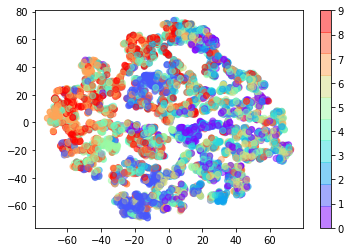

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_3 = TSNE(learning_rate=100)
print(z_cond_encoder_3.shape)
transformed_3 = model_3.fit_transform(z_cond_encoder_3[:6000, :])

xs_3 = transformed_3[:,0]
ys_3 = transformed_3[:,1]
plt.scatter(xs_3,ys_3,c=train_labels[:6000], cmap=plt.get_cmap('rainbow', 10), alpha=0.5)
plt.colorbar()
plt.show()

## 다음은 각 라벨별로 정규분포를 잘 따르는지 확인해보았다.
* 각 라벨별로 모두 정규분포를 유사하게 따르는 모습을 관찰할 수 있다.

(60000, 3)
(6000, 2)
6.251839


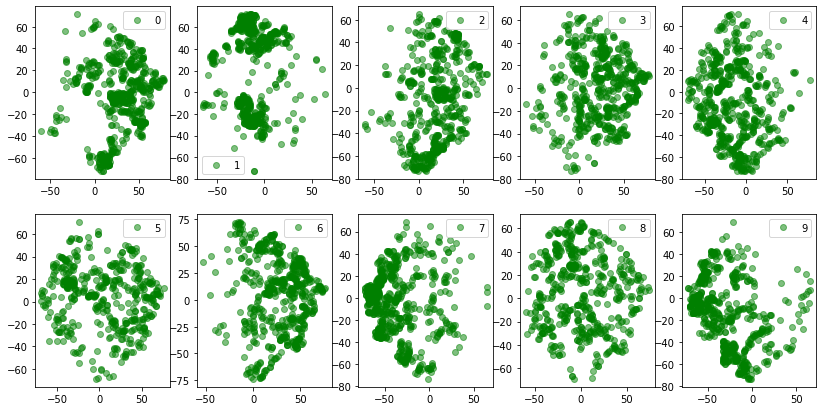

In [0]:
model_label_3 = TSNE(learning_rate=100)
print(z_cond_encoder_3.shape)
transformed_label_3 = model_label_3.fit_transform(z_cond_encoder_3[:6000, :])
print(transformed_label_3.shape)
print(transformed_label_3[0][0])
xs_label_3 = [[] for _ in range(10)]
ys_label_3 = [[] for _ in range(10)]
for i, j in enumerate(train_labels[:6000]):
    xs_label_3[j].append(transformed_label_3[i][0])
    ys_label_3[j].append(transformed_label_3[i][1])

plt.figure(figsize=(14,7))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label_3[i - 1], ys_label_3[i - 1], 'go', label=str(i - 1), alpha=0.5)
    ax.legend()

plt.show()

## 다음은 위의 가시화를 test images에 대해서 해본 것이다.

In [0]:
cond_encoder_test_3 = models.Model([z_img_3, z_con_3], z_enc_3)
z_cond_encoder_test_3 = cond_encoder_test_3([test_images, test_label_onehots])

## 다음은 TSNE를 통해서 가시화를 해보았다.
* 3차원을 2차원으로 줄여서 가시화를 하였다.
* 정규분포를 잘 따르는 것을 볼 수 있다.
* 하지만 위와 마찬가지로 각 라벨별로 뭉쳐있는 것을 볼 수 있다.

(10000, 3)


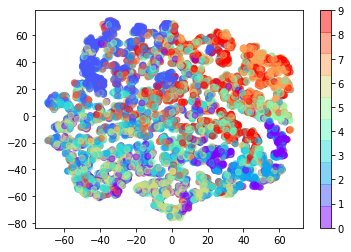

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_test_3 = TSNE(learning_rate=100)
print(z_cond_encoder_test_3.shape)
transformed_test_3 = model_test_3.fit_transform(z_cond_encoder_test_3[:, :])

xs_test_3 = transformed_test_3[:,0]
ys_test_3 = transformed_test_3[:,1]
plt.scatter(xs_test_3,ys_test_3,c=test_labels, cmap=plt.get_cmap('rainbow', 10), alpha=0.5)
plt.colorbar()
plt.show()

## 다음은 TSNE를 사용해서 각 조건별로 정규분포를 따르는지 확인해보았다.
* 라벨 1을 제외한 나머지는 모두 정규분포를 따르는 것 같다.

(10000, 3)


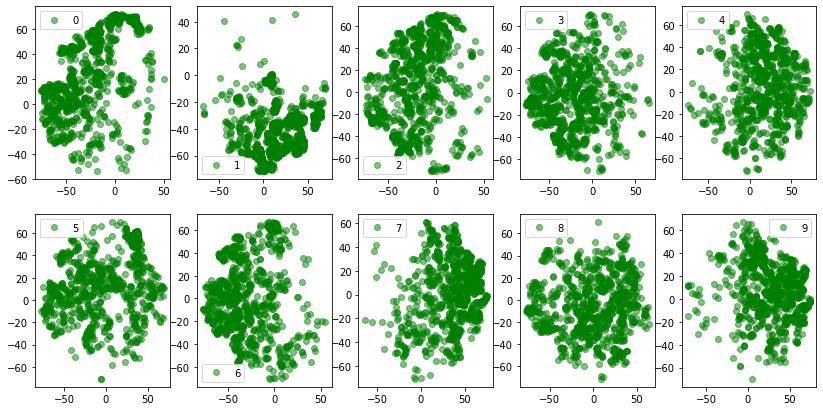

In [0]:
model_label_test_3 = TSNE(learning_rate=100)
print(z_cond_encoder_test_3.shape)
transformed_label_test_3 = model_label_test_3.fit_transform(z_cond_encoder_test_3[:, :])

xs_label_test_3 = [[] for _ in range(10)]
ys_label_test_3 = [[] for _ in range(10)]
for i, j in enumerate(test_labels):
    xs_label_test_3[j].append(transformed_label_test_3[i][0])
    ys_label_test_3[j].append(transformed_label_test_3[i][1])

plt.figure(figsize=(14,7))
for i in range(1, 11):
    ax = plt.subplot(2,5,i)
    ax.plot(xs_label_test_3[i - 1], ys_label_test_3[i - 1], 'go', label=str(i - 1), alpha=0.5)
    ax.legend()

plt.show()